## Initialize a Document Store

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()


/home/amadgakkhar/miniconda3/envs/haystack-ai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Fetch the Data

Data is of the form
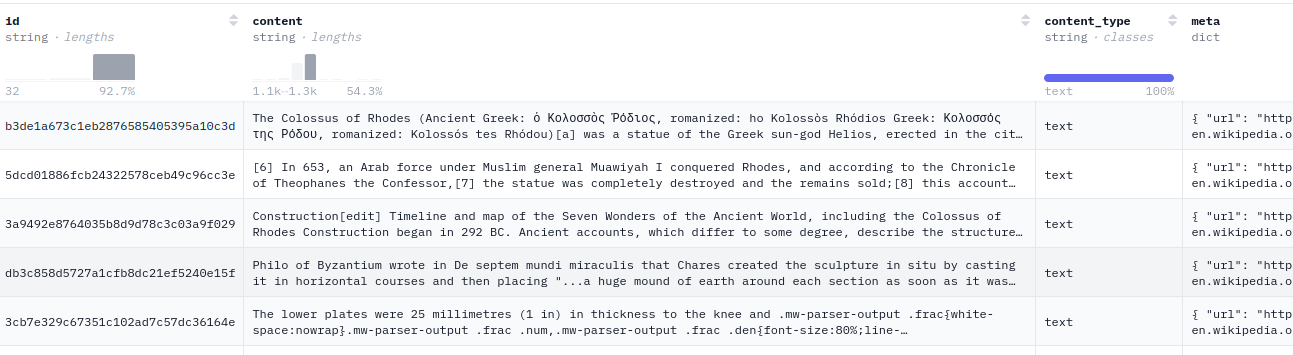

In [3]:
from datasets import load_dataset
from haystack import Document

dataset = load_dataset("bilgeyucel/seven-wonders", split="train")
docs = [Document(content=doc["content"], meta=doc["meta"]) for doc in dataset]


## Initalize a Document Embedder

To store your data in the DocumentStore with embeddings, initialize a SentenceTransformersDocumentEmbedder with the model name and call warm_up() to download the embedding model.

In [4]:
from haystack.components.embedders import SentenceTransformersDocumentEmbedder

doc_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
doc_embedder.warm_up()

/home/amadgakkhar/miniconda3/envs/haystack-ai/lib/python3.12/site-packages/sentence_transformers/SentenceTransformer.py:181: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v4 of SentenceTransformers.
  warnings.warn(
/home/amadgakkhar/miniconda3/envs/haystack-ai/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
docs_with_embeddings = doc_embedder.run(docs)

Batches: 100%|██████████| 5/5 [00:26<00:00,  5.32s/it]


In [6]:
import numpy as np

print(docs_with_embeddings['documents'][0].id)
print(docs_with_embeddings['documents'][0].content)
print(docs_with_embeddings['documents'][0].meta)
print(docs_with_embeddings['documents'][0].embedding)
print("Size of the vector embedding ",np.shape(docs_with_embeddings['documents'][0].embedding))


75fd8474f2c88337f7e0dad69eba0f24ba293cb06693fb746ec403df01a1c0c5
The Colossus of Rhodes (Ancient Greek: ὁ Κολοσσὸς Ῥόδιος, romanized: ho Kolossòs Rhódios Greek: Κολοσσός της Ρόδου, romanized: Kolossós tes Rhódou)[a] was a statue of the Greek sun-god Helios, erected in the city of Rhodes, on the Greek island of the same name, by Chares of Lindos in 280 BC. One of the Seven Wonders of the Ancient World, it was constructed to celebrate the successful defence of Rhodes city against an attack by Demetrius Poliorcetes, who had besieged it for a year with a large army and navy.
According to most contemporary descriptions, the Colossus stood approximately 70 cubits, or 33 metres (108 feet) high – approximately the height of the modern Statue of Liberty from feet to crown – making it the tallest statue in the ancient world.[2] It collapsed during the earthquake of 226 BC, although parts of it were preserved. In accordance with a certain oracle, the Rhodians did not build it again.[3] John Malal

In [7]:
document_store.write_documents(docs_with_embeddings["documents"])

151

In [8]:
print(document_store)

## RAG Pipeline

### Initialize Query Embedder

In [9]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")

### Initialize retriever

In [10]:
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
retriever = InMemoryEmbeddingRetriever(document_store)

### Prompt Template

In [11]:
from haystack.components.builders import PromptBuilder
template = """

Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:

"""
prompt_builder = PromptBuilder(template=template)

### Initialize Generator

In [12]:
import os
from haystack.utils import Secret
from haystack.components.generators import  OpenAIGenerator


llm = OpenAIGenerator(api_key = Secret.from_env_var("GROQ_API_KEY"),
                      api_base_url = "https://api.groq.com/openai/v1",
                      model="llama3-8b-8192",
                      generation_kwargs = {"max_tokens": 512}                      
                      )

### Build Pipeline

In [13]:
from haystack import Pipeline

rag_pipeline = Pipeline()
rag_pipeline.add_component("text_embedder", text_embedder)
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", llm)

rag_pipeline.connect("text_embedder.embedding","retriever.query_embedding")
rag_pipeline.connect("retriever","prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")


🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

In [26]:
rag_pipeline.draw(path="/home/amadgakkhar/code/Haystack/pipeline.mmd")

In [17]:
question = "What does Rhodes Statue look like?"

response = rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches: 100%|██████████| 1/1 [00:00<00:00, 24.75it/s]


According to the text, scholars do not know what the statue of Helios (Colossus of Rhodes) looked like, but they have a good idea of what the head and face looked like. The head would have had curly hair with evenly spaced spikes of bronze or silver flame radiating, similar to the images found on contemporary Rhodian coins.


In [19]:
print(response)

{'llm': {'replies': ['According to the text, scholars do not know what the statue of Helios (Colossus of Rhodes) looked like, but they have a good idea of what the head and face looked like. The head would have had curly hair with evenly spaced spikes of bronze or silver flame radiating, similar to the images found on contemporary Rhodian coins.'], 'meta': [{'model': 'llama3-8b-8192', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 71, 'prompt_tokens': 2424, 'total_tokens': 2495, 'queue_time': 0.002121943000000015, 'prompt_time': 0.295721725, 'completion_time': 0.059166667, 'total_time': 0.354888392}}]}}
